In [19]:
## B-spline class

import numpy as np
import matplotlib.pyplot as plt

class Bspline():
    
    def __init__(self, order, knots):
        
        self.knots = knots
        self.order = order
        self.degree = order - 1
        self.num_params = len(knots) + order
        
    def bspline_basis(self, x, k, i, t):
        """
        B-spline basis function value B(j,n) at x.
        
        Input arguments:
         x:
            value where the basis function is to be evaluated
         n:
            B-spline order (2 for linear, 1 for quadratic, etc.)
         i:
            interval index, 0 =< j < numel(t)-k-1

         t:
            knot vector

         Output arguments:
         y:
        
        """
        if k == 0:

            return 1.0 if t[i] <= x < t[i+1] else 0.0

        if t[i+k] == t[i]:

            c1 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:
            
            c1 = (x - t[i])/(t[i+k] - t[i]) * self.bspline_basis(x, k-1, i, t)

        if t[i+k+1] == t[i+1]:

            c2 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:

            c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * self.bspline_basis(x, k-1, i+1, t)
        
        return c1 + c2
    
    def basis_matrix(self, x):
        """
        B-spline basis function value matrix B(n) for x.
        
        Input arguments:
         n:
            B-spline order (2 for linear, 3 for quadratic, etc.)
         t:
            knot vector
         x (optional):
            an m-dimensional vector of values where the basis function is to be
            evaluated
        
        Output arguments:
         B:
            a matrix of m rows and numel(t)-n columns
        """
        n = self.order
        t = self.knots
        k = n-1
        
        B = np.zeros((len(x),len(t) - n))
        
        for i in range(len(t) - n):
            for j in range(len(x)):
                B[j,i] = self.bspline_basis(x[j], k, i, t)
            
        return B
        
    def fit(self, x_data, y_data):
        
        Bmat =  self.basis_matrix(x_data)

        #Solve least squares y = B * c
        self.coeffs = np.linalg.lstsq(Bmat, y_data)[0]
        
    def predict(self, x_pred, coeffs = None):
        
        if coeffs is None:
            coeffs = self.coeffs

        Bmat =  self.basis_matrix(x_pred)
        
        y_pred = Bmat @ coeffs
        
        return y_pred

<ipython-input-19-a29211f1dc53>:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.coeffs = np.linalg.lstsq(Bmat, y_data)[0]


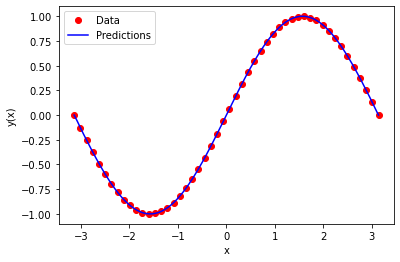

In [20]:
## TEST ##

x_data = np.linspace(-np.pi, np.pi, 50)
x_pred = np.linspace(-np.pi, np.pi, 200)
y_data = np.sin(x_data)
knots = np.concatenate(([x_data[0]]*3, x_data, [x_data[-1]]*3))

degree = 3
order = degree + 1

bs = Bspline(order, knots)

bs.fit(x_data, y_data)
y_pred = bs.predict(x_pred)

plt.plot(x_data, y_data, 'ro')
plt.plot(x_pred, y_pred,'b')
plt.ylabel('y(x)')
plt.xlabel('x')
plt.legend(['Data','Predictions'])

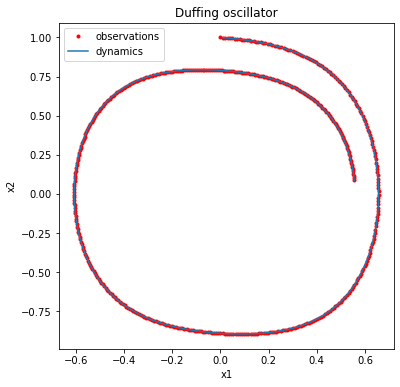

In [21]:

from scipy.integrate import odeint
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    return [
            x[1],
            -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3
            ]

gamma=0.1
kappa=1
epsilon=5

####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 5 # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
t_span_half = 0.5 * (t_span[0:-1] + t_span[1:])
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
X_half = odeint(duffing, x0, np.insert(t_span_half,0,0))
X_half = X_half[1:]# For midpoint rule

x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -gamma * x2 - kappa * x1 - epsilon * x1 ** 3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

<ipython-input-19-a29211f1dc53>:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.coeffs = np.linalg.lstsq(Bmat, y_data)[0]


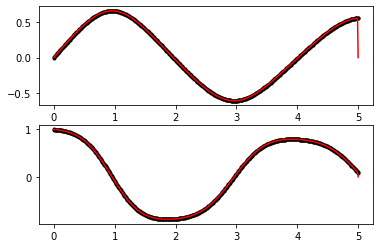

In [22]:
knots_t = np.concatenate([[t[0]]*3, t, [t[-1]]*3])
# knots_t = np.concatenate([[t[0]]*3, t])

order = 4

bs_duff_x = Bspline(order, knots_t)
bs_duff_y = Bspline(order, knots_t)

t0, tf = 0, 5 # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
t_pred = np.linspace(t0, tf, n_times)

bs_duff_x.fit(t, y1)
bs_duff_y.fit(t, y2)

x_pred = bs_duff_x.predict(t_pred)
y_pred = bs_duff_y.predict(t_pred)

fig, ax = plt.subplots(2,1)
ax[0].plot(t, y1,'k.')
ax[0].plot(t_pred, x_pred,'r')
ax[1].plot(t, y2,'k.')
ax[1].plot(t_pred, y_pred,'r')
